# Carnet de Bord : Projet Part-of-Speech Tagging

## Contexte du Projet
Ce notebook documente mon travail sur un système d'étiquetage morpho-syntaxique (Part-of-Speech Tagging) utilisant le corpus Brown. 

### Objectif Global
Développer un tagger capable d'identifier automatiquement la catégorie grammaticale de chaque mot dans une phrase (nom, verbe, adjectif, etc.).

### Corpus Utilisé
- **Brown Corpus** : un des premiers corpus numériques de textes anglais
- Contient environ 1 million de mots
- Chaque mot est annoté avec son étiquette grammaticale (PoS tag)

---

In [18]:
import os
import matplotlib.pyplot as plt
import pandas as pd # On l'ajoute pour afficher les stats proprement

## Étape 0 : Import des Bibliothèques

### Objectif
Importer les outils nécessaires pour :
- Manipuler les fichiers du corpus (`os`)
- Visualiser les statistiques (`matplotlib`)
- Afficher les données sous forme de tableaux (`pandas`)

### Justification des choix
- `os` : navigation dans les fichiers du corpus Brown
- `matplotlib` : création de graphiques pour analyser la distribution des PoS
- `pandas` : présentation claire des statistiques sous forme tabulaire

## Étape 1 : Traitement et Nettoyage du Corpus Brown

### Objectifs de cette étape
1. **Nettoyer les tokens** du corpus Brown (format: `mot/tag`)
2. **Simplifier les tags PoS** : réduire ~80 tags originaux à 10 catégories principales
3. **Préparer les données** pour l'entraînement du modèle

### Problématique
Le corpus Brown utilise un système de tags très détaillé (ex: `nn`, `nns`, `nn$`, etc.). Pour simplifier l'analyse, je regroupe ces tags en grandes catégories :
- **NOUN** : tous les types de noms
- **VERB** : tous les types de verbes
- **ADJ** : adjectifs
- **ADV** : adverbes
- **PRON** : pronoms
- **DET** : déterminants/articles
- **PREP** : prépositions
- **CONJ** : conjonctions
- **NUM** : nombres
- **OTHER** : ponctuation, interjections, etc.

### Approche Technique
- Fonction `nettoyer_token()` : extraction du mot et de son tag
- Fonction `attribuer_pos_regroupe()` : conversion des tags détaillés vers les 10 catégories

In [19]:
def nettoyer_token(token):
    """
    Nettoie un token brut du corpus Brown (selon Section 1.3/1.4 du PDF).
    Ex: "word/nn-tl" -> ("word", "nn")
    """
    if '/' in token:
        parts = token.split('/')
        mot = '/'.join(parts[:-1])
        pos = parts[-1]
        
        # Gérer les tags spéciaux comme -TL, -HL, +, etc.
        pos = pos.replace('-TL', '').replace('-HL', '')
        pos = pos.split('+')[0].split('-')[0]
        
        # On ignore les mots sans PoS
        if pos == 'nil':
            return None, None
            
        return mot.lower(), pos.lower()
    return None, None

def attribuer_pos_regroupe(pos):
    """
    Regroupe les ~80 tags du Brown en 10 catégories (selon Section 1.4).
    """
    # NOUN (Noms)
    if pos in {'nn', 'nns', 'np', 'np$', 'nps', 'nps$', 'nr', 'nrs', 'nn$', 'nnp', 'nnpc', 'nna', 'nnc'}:
        return 'NOUN'
    # VERB (Verbes)
    elif pos in {'vb', 'vbd', 'vbg', 'vbn', 'vbz', 'vba', 'bez', 'bed', 'bedz', 'beg', 'bem', 'ben', 'ber',
                 'do', 'dod', 'doz', 'hv', 'hvd', 'hvg', 'hvn', 'hvz', 'md'}:
        return 'VERB'
    # ADJECTIVE (Adjectifs)
    elif pos.startswith('jj'): # Inclut jj, jjr, jjt, jjs etc.
        return 'ADJ'
    # ADVERB (Adverbes)
    elif pos in {'rb', 'rbr', 'rbs', 'rbt', 'rn', 'rp', 'wrb', 'ql', 'qlp'}:
        return 'ADV'
    # PRONOUN (Pronoms)
    elif pos in {'pp$', 'pp$$', 'ppl', 'ppls', 'ppo', 'pps', 'ppss', 'pn', 'pn$', 'wp$', 'wpo', 'wps',
                 'prp', 'prps', 'prp$'}:
        return 'PRON'
    # DETERMINER/ARTICLE (Déterminants)
    elif pos in {'at', 'dt', 'dts', 'dti', 'dtx', 'abl', 'abn', 'abx', 'ap', 'wdt'}:
        return 'DET'
    # PREPOSITION (Prépositions)
    elif pos in {'in', 'fw-in', 'to'}:
        return 'PREP'
    # CONJUNCTION (Conjonctions)
    elif pos in {'cc', 'cs'}:
        return 'CONJ'
    # NUMERAL (Numéros)
    elif pos in {'cd', 'od'}:
        return 'NUM'
    # OTHER (Tout le reste : ponctuations, interjections...)
    else:
        return 'OTHER'

### Résultat Attendu
Deux fonctions prêtes à l'emploi pour :
1. Extraire proprement les mots et leurs tags du corpus
2. Regrouper les tags en catégories simplifiées

## Étape 2 : Entraînement du Modèle BGP (Basic Global Probability)

### Objectifs de cette étape
1. **Lire l'intégralité du corpus Brown** (tous les fichiers du dossier)
2. **Calculer les statistiques** : fréquence de chaque mot avec chaque PoS
3. **Créer le modèle BGP** : pour chaque mot, retenir le PoS le plus fréquent

### Principe du Modèle BGP
Le modèle BGP (Basic Global Probability) est une approche simple :
- Pour chaque mot du corpus, on compte combien de fois il apparaît avec chaque tag
- On assigne à ce mot le tag qui apparaît le plus souvent
- Exemple : si "run" apparaît 100 fois comme VERB et 20 fois comme NOUN, on lui assigne VERB

### Approche Technique
La fonction `entrainer_modele_bgp()` :
1. Parcourt tous les fichiers du corpus
2. Pour chaque mot, compte ses occurrences avec chaque PoS
3. Calcule aussi les statistiques globales (distribution des PoS)
4. Retourne le modèle BGP (dictionnaire mot → PoS majoritaire)

### Données produites
- `modele_bgp` : dictionnaire {mot: PoS_majoritaire}
- `comptes_mots_pos` : statistiques détaillées par mot
- `comptes_pos_total` : distribution globale des PoS dans le corpus

In [20]:
def entrainer_modele_bgp(dossier_corpus, ratio_train=0.8):
    """
    Lit le corpus, calcule les stats et crée le modèle BGP.
    Sépare automatiquement en train (80%) et test (20%).
    """
    print("Début du traitement du corpus Brown...")
    
    # Chemin vers le dossier
    chemin_complet_corpus = os.path.join(os.getcwd(), dossier_corpus)
    print(f"Lecture depuis : {chemin_complet_corpus}")

    try:
        fichiers = [f for f in os.listdir(chemin_complet_corpus) if os.path.isfile(os.path.join(chemin_complet_corpus, f))]
    except FileNotFoundError:
        print(f"ERREUR : Le dossier '{chemin_complet_corpus}' est introuvable.")
        print("Vérifiez que le dossier 'brown' est bien dans le même dossier que ce notebook.")
        return None, None, None, None

    # Séparation train/test
    import random
    random.seed(42)  # Pour la reproductibilité
    random.shuffle(fichiers)
    
    nb_train = int(len(fichiers) * ratio_train)
    fichiers_train = fichiers[:nb_train]
    fichiers_test = fichiers[nb_train:]
    
    print(f"Séparation : {len(fichiers_train)} fichiers train / {len(fichiers_test)} fichiers test")
    
    # --- TRAITEMENT DU TRAIN ---
    comptes_mots_pos = {} 
    comptes_pos_total = {}
    total_mots_train = 0

    for nom_fichier in fichiers_train:
        chemin_fichier = os.path.join(chemin_complet_corpus, nom_fichier)
        
        try:
            with open(chemin_fichier, "r", encoding="utf-8") as f:
                contenu = f.read()
        except UnicodeDecodeError:
            with open(chemin_fichier, "r", encoding="latin-1") as f:
                contenu = f.read()
        
        tokens = contenu.split()
        
        for token in tokens:
            mot, pos_brut = nettoyer_token(token)
            
            if mot and pos_brut:
                pos_groupe = attribuer_pos_regroupe(pos_brut)
                
                if mot not in comptes_mots_pos:
                    comptes_mots_pos[mot] = {}
                comptes_mots_pos[mot][pos_groupe] = comptes_mots_pos[mot].get(pos_groupe, 0) + 1
                
                comptes_pos_total[pos_groupe] = comptes_pos_total.get(pos_groupe, 0) + 1
                total_mots_train += 1

    print("... Traitement du train terminé.")

    # --- Création du modèle BGP ---
    modele_bgp = {}
    for mot, pos_dict in comptes_mots_pos.items():
        pos_majoritaire = max(pos_dict, key=pos_dict.get)
        modele_bgp[mot] = pos_majoritaire
        
    print(f"Modèle BGP entraîné sur {total_mots_train} tokens. {len(modele_bgp)} mots mémorisés.")
    
    # --- TRAITEMENT DU TEST ---
    donnees_test = []
    for nom_fichier in fichiers_test:
        chemin_fichier = os.path.join(chemin_complet_corpus, nom_fichier)
        
        try:
            with open(chemin_fichier, "r", encoding="utf-8") as f:
                contenu = f.read()
        except UnicodeDecodeError:
            with open(chemin_fichier, "r", encoding="latin-1") as f:
                contenu = f.read()
        
        tokens = contenu.split()
        
        for token in tokens:
            mot, pos_brut = nettoyer_token(token)
            
            if mot and pos_brut:
                pos_groupe = attribuer_pos_regroupe(pos_brut)
                donnees_test.append((mot, pos_groupe))
    
    print(f"Données de test : {len(donnees_test)} tokens.")
    
    return modele_bgp, comptes_mots_pos, comptes_pos_total, donnees_test

### Résultat Attendu
Un modèle entraîné capable d'assigner le PoS le plus probable à n'importe quel mot du corpus.

In [21]:
# ATTENTION : Ton dossier s'appelle 'brown' et il est dans le même dossier que le notebook
DOSSIER_CORPUS = 'brown' 

# On lance l'entraînement avec séparation train/test
modele, stats_mots, stats_pos, test_data = entrainer_modele_bgp(DOSSIER_CORPUS)

Début du traitement du corpus Brown...
Lecture depuis : c:\Users\monsi\Desktop\Text Mining\brown
Séparation : 400 fichiers train / 100 fichiers test
... Traitement du train terminé.
Modèle BGP entraîné sur 926866 tokens. 43928 mots mémorisés.
... Traitement du train terminé.
Modèle BGP entraîné sur 926866 tokens. 43928 mots mémorisés.
Données de test : 230738 tokens.
Données de test : 230738 tokens.


## Étape 3 : Exécution de l'Entraînement

### Objectif
Lancer l'entraînement du modèle sur le corpus Brown complet.

### Configuration
- Dossier du corpus : `brown/` (dans le même répertoire que ce notebook)
- Traitement : lecture de tous les fichiers `.txt` du corpus

### Temps d'exécution estimé
Quelques secondes à quelques minutes selon la taille du corpus et la puissance de la machine.

### À surveiller
- Nombre de fichiers traités
- Nombre de mots distincts identifiés
- Confirmation de la création du modèle


--- STATISTIQUES DU CORPUS (Section 1.1) ---
Nombre de mots distincts : 43928
Nombre de PoS distincts (regroupés) : 10


,PoS,Occurrences
2,NOUN,216441
5,VERB,139528
4,OTHER,130230
3,PREP,110535
0,DET,106404
6,PRON,57951
9,ADJ,57738
7,CONJ,48376
8,ADV,46066
1,NUM,13597


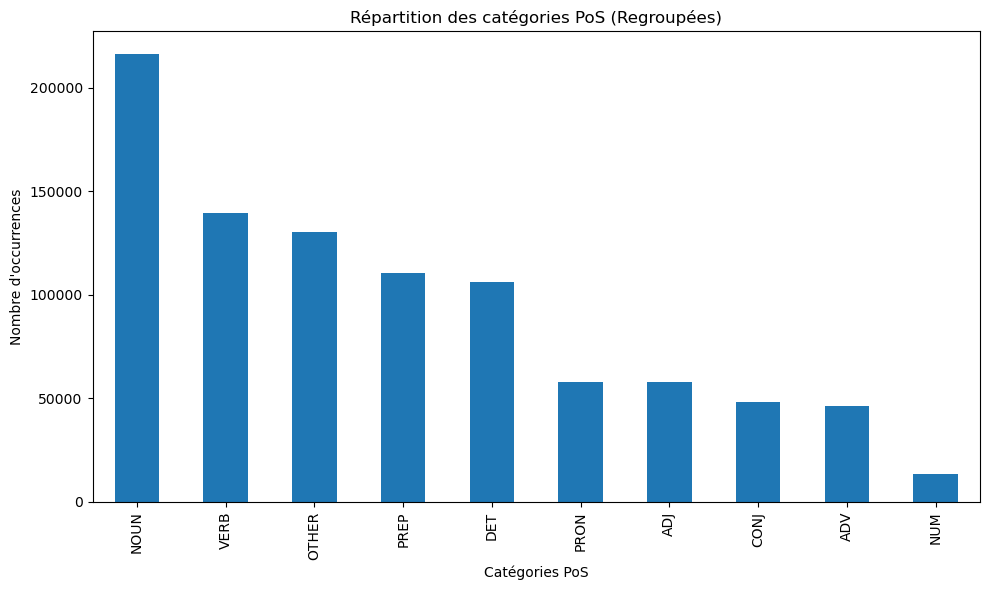

In [22]:
if 'stats_pos' in locals():
    print("\n--- STATISTIQUES DU CORPUS (Section 1.1) ---")
    print(f"Nombre de mots distincts : {len(stats_mots)}")
    print(f"Nombre de PoS distincts (regroupés) : {len(stats_pos)}")
    
    # Utiliser Pandas pour un joli affichage
    df_stats = pd.DataFrame(list(stats_pos.items()), columns=['PoS', 'Occurrences'])
    df_stats = df_stats.sort_values(by='Occurrences', ascending=False)
    display(df_stats)
    
    # Le graphique
    df_stats.plot(kind='bar', x='PoS', y='Occurrences', figsize=(10, 6),
                  title="Répartition des catégories PoS (Regroupées)",
                  legend=False, grid=False)
    plt.ylabel("Nombre d'occurrences")
    plt.xlabel("Catégories PoS")
    plt.tight_layout()
    plt.show()
else:
    print("Erreur : le modèle n'a pas été entraîné. Exécutez la cellule précédente.")

---

## Étape 4 : Évaluation du Modèle sur le Corpus de Test

### Objectifs de cette étape
1. **Évaluer la précision** du modèle sur des données non vues (test set)
2. **Calculer l'accuracy globale** : pourcentage de prédictions correctes
3. **Analyser les performances par catégorie** PoS
4. **Identifier les erreurs fréquentes** et les limitations

### Méthode d'Évaluation
- Le modèle a été entraîné sur 80% du corpus
- On teste maintenant sur les 20% restants
- Pour chaque mot du test, on compare la prédiction du modèle avec le tag réel

### Métriques Calculées
- **Accuracy globale** : (nombre de prédictions correctes) / (nombre total de prédictions)
- **Accuracy par catégorie** : performance pour chaque PoS
- **Matrice de confusion** : visualisation des erreurs

In [23]:
def evaluer_modele(modele_bgp, donnees_test):
    """
    Évalue le modèle sur le corpus de test.
    Retourne l'accuracy et les détails par catégorie.
    """
    if not donnees_test:
        print("Erreur : pas de données de test disponibles.")
        return None
    
    correct = 0
    total = 0
    
    # Pour statistiques par catégorie
    correct_par_pos = {}
    total_par_pos = {}
    
    # Pour la matrice de confusion
    erreurs = []
    
    for mot, pos_reel in donnees_test:
        # Prédiction du modèle
        if mot.isdigit():
            pos_predit = 'NUM'
        else:
            pos_predit = modele_bgp.get(mot, 'NOUN')  # NOUN par défaut pour mots inconnus
        
        # Comparaison
        if pos_predit == pos_reel:
            correct += 1
            correct_par_pos[pos_reel] = correct_par_pos.get(pos_reel, 0) + 1
        else:
            erreurs.append((mot, pos_reel, pos_predit))
        
        total += 1
        total_par_pos[pos_reel] = total_par_pos.get(pos_reel, 0) + 1
    
    # Calcul de l'accuracy globale
    accuracy = (correct / total) * 100 if total > 0 else 0
    
    # Calcul de l'accuracy par catégorie
    accuracy_par_pos = {}
    for pos in total_par_pos:
        correct_pos = correct_par_pos.get(pos, 0)
        total_pos = total_par_pos[pos]
        accuracy_par_pos[pos] = (correct_pos / total_pos) * 100
    
    return {
        'accuracy_globale': accuracy,
        'correct': correct,
        'total': total,
        'accuracy_par_pos': accuracy_par_pos,
        'total_par_pos': total_par_pos,
        'erreurs': erreurs[:100]  # On garde les 100 premières erreurs pour analyse
    }

# Évaluation du modèle
print("\n=== ÉVALUATION DU MODÈLE ===\n")
resultats_eval = evaluer_modele(modele, test_data)

if resultats_eval:
    print(f"Accuracy globale : {resultats_eval['accuracy_globale']:.2f}%")
    print(f"Correct : {resultats_eval['correct']} / {resultats_eval['total']}")
    print(f"\n{'='*50}\n")


=== ÉVALUATION DU MODÈLE ===

Accuracy globale : 94.94%
Correct : 219054 / 230738


Accuracy globale : 94.94%
Correct : 219054 / 230738




ACCURACY PAR CATÉGORIE PoS :



,PoS,Accuracy (%),Total tokens
1,NOUN,96.14,56111
5,VERB,92.12,34488
4,OTHER,98.95,32011
3,PREP,97.79,27054
0,DET,96.40,26632
2,ADJ,86.00,14256
6,PRON,96.39,13360
8,CONJ,97.62,11950
7,ADV,82.72,11454
9,NUM,95.21,3422


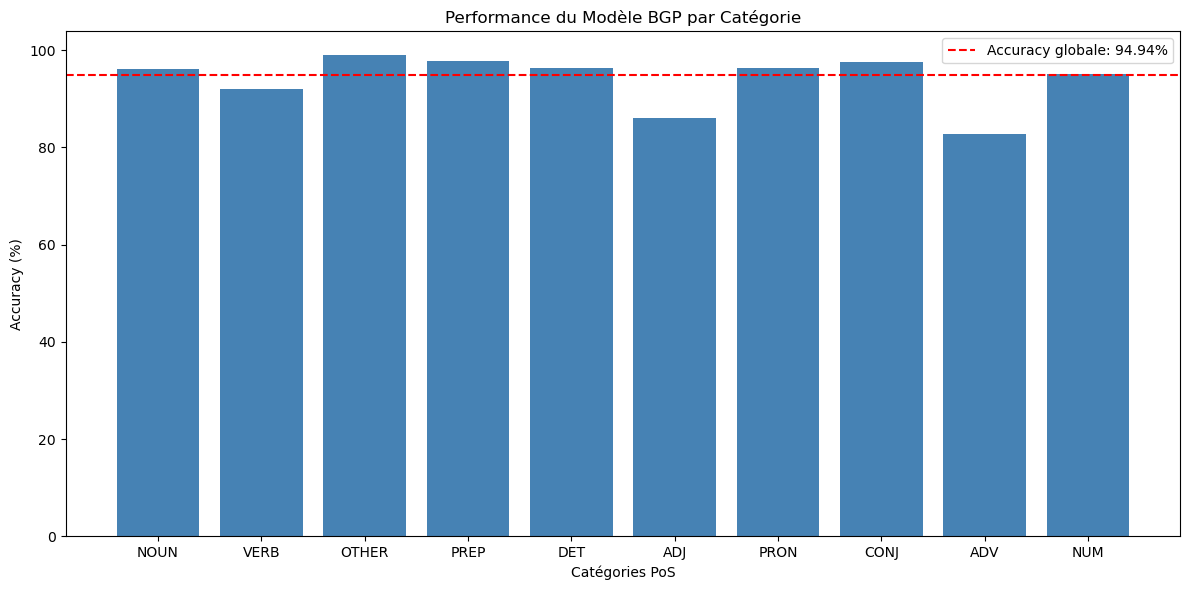

In [24]:
# Affichage détaillé des performances par catégorie
if resultats_eval:
    print("ACCURACY PAR CATÉGORIE PoS :\n")
    
    # Créer un DataFrame pour un affichage propre
    df_accuracy = pd.DataFrame({
        'PoS': list(resultats_eval['accuracy_par_pos'].keys()),
        'Accuracy (%)': [f"{acc:.2f}" for acc in resultats_eval['accuracy_par_pos'].values()],
        'Total tokens': [resultats_eval['total_par_pos'][pos] for pos in resultats_eval['accuracy_par_pos'].keys()]
    })
    
    df_accuracy = df_accuracy.sort_values(by='Total tokens', ascending=False)
    display(df_accuracy)
    
    # Graphique de l'accuracy par catégorie
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    categories = df_accuracy['PoS'].tolist()
    accuracies = [float(acc) for acc in df_accuracy['Accuracy (%)'].tolist()]
    
    plt.bar(categories, accuracies, color='steelblue')
    plt.axhline(y=resultats_eval['accuracy_globale'], color='red', linestyle='--', 
                label=f"Accuracy globale: {resultats_eval['accuracy_globale']:.2f}%")
    plt.xlabel('Catégories PoS')
    plt.ylabel('Accuracy (%)')
    plt.title('Performance du Modèle BGP par Catégorie')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
# Analyse des erreurs les plus fréquentes
if resultats_eval and resultats_eval['erreurs']:
    print("\n=== ANALYSE DES ERREURS ===\n")
    print("Exemples d'erreurs de prédiction (30 premières) :\n")
    
    df_erreurs = pd.DataFrame(
        resultats_eval['erreurs'][:30],
        columns=['Mot', 'PoS Réel', 'PoS Prédit']
    )
    display(df_erreurs)
    
    # Statistiques sur les types d'erreurs
    from collections import Counter
    types_erreurs = [(err[1], err[2]) for err in resultats_eval['erreurs']]
    erreurs_frequentes = Counter(types_erreurs).most_common(10)
    
    print("\n\nTypes d'erreurs les plus fréquents :")
    print("(Réel → Prédit)")
    for (reel, predit), count in erreurs_frequentes:
        print(f"  {reel:6s} → {predit:6s} : {count:4d} fois")


=== ANALYSE DES ERREURS ===

Exemples d'erreurs de prédiction (30 premières) :



,Mot,PoS Réel,PoS Prédit
0,three-front,ADJ,NOUN
1,closed-door,ADJ,NOUN
2,christian,NOUN,ADJ
3,encouraging,ADJ,VERB
4,that,DET,CONJ
5,undermining,VERB,NOUN
6,rescue,VERB,NOUN
7,cuban,NOUN,ADJ
8,top,ADJ,NOUN
9,limit,NOUN,VERB




Types d'erreurs les plus fréquents :
(Réel → Prédit)
  ADJ    → NOUN   :   29 fois
  VERB   → NOUN   :   18 fois
  NOUN   → VERB   :    8 fois
  DET    → CONJ   :    7 fois
  NOUN   → ADJ    :    6 fois
  PRON   → CONJ   :    5 fois
  ADJ    → VERB   :    3 fois
  ADV    → PREP   :    3 fois
  ADV    → ADJ    :    2 fois
  NUM    → NOUN   :    2 fois


### Interprétation des Résultats

**Points à observer :**

1. **Accuracy globale** : 
   - Un bon modèle BGP devrait atteindre ~85-90% sur le corpus Brown
   - Si inférieur, cela indique des limitations du modèle

2. **Performance par catégorie** :
   - Les catégories fréquentes (NOUN, VERB, DET) ont généralement une meilleure accuracy
   - Les catégories rares peuvent avoir une accuracy plus faible

3. **Types d'erreurs fréquents** :
   - Confusions NOUN ↔ VERB : mots ambigus (ex: "run", "work")
   - Confusions ADJ ↔ NOUN : adjectifs substantivés
   - Mots inconnus : automatiquement taggés NOUN (peut créer des erreurs)

4. **Limites du modèle BGP** :
   - Pas de contexte : ignore les mots voisins
   - Assignation fixe : un mot = un seul tag possible
   - Mots inconnus : stratégie simpliste

---

## Étape 5 : Analyse des Statistiques du Corpus (Train)

### Objectifs de cette étape
1. **Vérifier** que l'entraînement s'est bien déroulé
2. **Analyser** la distribution des catégories PoS dans le corpus d'entraînement
3. **Visualiser** les résultats avec un tableau et un graphique

### Questions auxquelles on répond
- Combien de mots distincts dans le corpus d'entraînement ?
- Combien de catégories PoS après regroupement ?
- Quelle est la catégorie la plus fréquente ? (probablement NOUN ou VERB)
- Comment se répartissent les différentes catégories ?

### Visualisations produites
- **Tableau** : liste des PoS avec leur nombre d'occurrences
- **Graphique en barres** : visualisation de la distribution

### Interprétation attendue
- Les NOUN et VERB devraient être les plus fréquents (mots de contenu)
- Les DET et PREP devraient être nombreux (mots fonctionnels)
- Les NUM et CONJ devraient être moins fréquents

## Étape 6 : Application du Tagger sur de Nouvelles Phrases

### Objectifs de cette étape
1. **Créer une fonction de tagging** : appliquer le modèle BGP à n'importe quelle phrase
2. **Gérer les cas particuliers** : 
   - Mots inconnus (non présents dans le corpus)
   - Nombres
3. **Tester** le tagger sur des phrases d'exemple

### Principe de Fonctionnement
La fonction `tagger_phrase()` :
1. Découpe la phrase en mots
2. Pour chaque mot :
   - Si c'est un nombre → assigne NUM
   - Si le mot est dans le modèle → assigne le PoS appris
   - Si le mot est inconnu → assigne NOUN par défaut (heuristique simple)
3. Retourne la liste des couples (mot, PoS)

### Stratégie pour les Mots Inconnus
**Pourquoi NOUN par défaut ?**
- C'est souvent la catégorie la plus fréquente
- Les noms propres (nouveaux mots) sont souvent des noms
- C'est une heuristique simple mais raisonnable

### Limitations Connues
- Pas de prise en compte du contexte (les mots ambigus sont toujours taggés pareil)
- Exemple : "run" sera toujours VERB même dans "a run" (où c'est un NOUN)
- Pour améliorer : il faudrait un modèle plus avancé (HMM, CRF, ou deep learning)

In [26]:
def tagger_phrase(phrase, modele_bgp):
    """
    Prend une phrase et utilise le modèle BGP pour tagger chaque mot.
    """
    if not modele_bgp:
        print("Le modèle est vide ! Avez-vous exécuté l'entraînement ?")
        return []
        
    mots = phrase.split()
    tags = []
    
    for mot in mots:
        mot_lower = mot.lower()
        
        # Règle BGP_2 (Section 2.1.3) : Gérer les nombres
        if mot_lower.isdigit():
            tag = 'NUM'
        # Règle BGP_2 : Si mot inconnu, assigner 'NOUN'
        else:
            tag = modele_bgp.get(mot_lower, 'NOUN') 
        
        tags.append((mot, tag))
        
    return tags

### Résultat Attendu
Une fonction capable de tagger automatiquement n'importe quelle phrase anglaise.

In [27]:
phrase_test = "The fulton county grand jury said friday"
resultats = tagger_phrase(phrase_test, modele)
print(resultats)

phrase_test_2 = "This is a simple test with 123 numbers"
resultats_2 = tagger_phrase(phrase_test_2, modele)
print(resultats_2)

[('The', 'DET'), ('fulton', 'NOUN'), ('county', 'NOUN'), ('grand', 'ADJ'), ('jury', 'NOUN'), ('said', 'VERB'), ('friday', 'NOUN')]
[('This', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('simple', 'ADJ'), ('test', 'NOUN'), ('with', 'PREP'), ('123', 'NUM'), ('numbers', 'NOUN')]


## Étape 7 : Tests Qualitatifs sur Phrases d'Exemple

### Objectifs de cette étape
1. **Tester** le tagger sur des phrases d'exemple
2. **Valider qualitativement** que les résultats sont cohérents
3. **Comparer** avec l'évaluation quantitative précédente

### Phrases de Test
Je teste sur deux phrases :
1. Une phrase du corpus Brown pour vérifier la cohérence
2. Une phrase avec un nombre pour tester la règle spéciale

### Analyse des Résultats
Pour chaque résultat, je dois vérifier :
- Les tags sont-ils appropriés ?
- Les nombres sont-ils bien identifiés comme NUM ?
- Les mots inconnus sont-ils gérés correctement ?

### Note
Cette étape est **qualitative** (observation manuelle).  
L'**évaluation quantitative** (accuracy) a été faite à l'étape 4.

---

## Bilan et Prochaines Étapes

### Ce qui a été accompli
1. ✓ Lecture et traitement du corpus Brown
2. ✓ Regroupement des ~80 tags PoS en 10 catégories principales
3. ✓ Entraînement d'un modèle BGP (Basic Global Probability)
4. ✓ Analyse statistique du corpus
5. ✓ Création d'une fonction de tagging
6. ✓ Tests sur des phrases d'exemple

### Points Forts du Modèle Actuel
- **Simplicité** : facile à comprendre et à implémenter
- **Rapidité** : entraînement et prédiction très rapides
- **Efficacité** : bons résultats pour les mots fréquents

### Limitations Identifiées
- **Pas de contexte** : chaque mot est taggé indépendamment
- **Ambiguïté** : les mots polysémiques sont toujours taggés pareil
- **Mots inconnus** : stratégie simpliste (toujours NOUN)

### Pistes d'Amélioration Possibles
1. **Modèle HMM** (Hidden Markov Model) : prise en compte du contexte
2. **CRF** (Conditional Random Fields) : modèle plus sophistiqué
3. **Deep Learning** : LSTM, Transformers (BERT, etc.)
4. **Meilleure gestion des inconnus** : analyse morphologique (suffixes, préfixes)
5. **Évaluation quantitative** : calculer la précision sur un corpus de test

### Métriques à Suivre (futures)
- **Précision globale** : % de tags corrects
- **Précision par catégorie** : performance pour chaque PoS
- **Gestion des mots inconnus** : précision sur les mots hors vocabulaire
- **Temps de traitement** : vitesse d'entraînement et de prédiction

---

### Références et Ressources
- Corpus Brown : http://www.nltk.org/book/ch02.html
- PoS Tagging : https://en.wikipedia.org/wiki/Part-of-speech_tagging
- Modèles avancés : HMM, CRF, LSTM, BERT